In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

This script take a (.png) heightmap image and create a 3d stl description out of it. 
----------------------------------------------------------------------------------------------------

Input: 
  - image_name:  the path of the image file

Parameters:
   - color_componant: which of the RGB color componant is encoding the height 
   - horizontal_mm_per_pixel: The object is created to have a size which is given by the number of pixel times this parameter in [mm]
   - vertical_range: the [0-255] color range is stretched to a height range given by [0,vertical_range] in [mm]
   - bottom_position: the bottom of the object is offseted by this value in [mm]
   
Output:
   - a .stl closed object which can be directly imported in 3D programs (tested in Blender) Warning the file can be quite big...

In [12]:
image_name = "test.png" # name of the file
color_componant = 0 #0=R, 1=G, 2=B
horizontal_mm_per_pixel = 1.004 #[mm/pixel]
vertical_range = 43   #[mm]
bottom_position = 0 #[mm]


-----------------------------------------------------------------------------------------------------

In [13]:
v_r= vertical_range/256

In [14]:

img = Image.open(image_name)
img_array=np.asarray(img)

In [15]:
img_array.shape

(250, 640, 4)

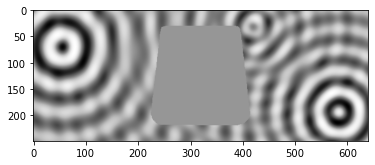

In [16]:
plt.imshow(img_array, cmap="Greys_r")

In [17]:
def normalize(v):
    norm = (v[0]**2+v[1]**2+v[2]**2)**0.5
    return np.array(v)/norm

In [18]:
def pilTriangle(p1,p2,p3):
    v1=np.array(p2)-np.array(p1)
    v2=np.array(p3)-np.array(p1)
    n=np.array([v1[1]*v2[2] - v1[2]*v2[1], v1[2]*v2[0] - v1[0]*v2[2], v1[0]*v2[1] - v1[1]*v2[0]])
    n = normalize(n)
    
    pil = "facet normal {} {} {} \n".format(n[0], n[1], n[2])
    pil = pil + "  outer loop\n"
    pil = pil + "    vertex {} {} {}\n".format(p1[0], p1[1], p1[2])
    pil = pil + "    vertex {} {} {}\n".format(p2[0], p2[1], p2[2])
    pil = pil + "    vertex {} {} {}\n".format(p3[0], p3[1], p3[2])
    pil = pil + "  endloop\n"
    pil = pil + "endfacet\n"
    return pil

In [19]:
def pilRect(p1,p2,p3,p4):
    med = 0.25*(np.array(p1)+np.array(p2)+np.array(p3)+np.array(p4))
    pil = pilTriangle(p1,p2,med)
    pil = pil + pilTriangle(p2,p3,med)
    pil = pil + pilTriangle(p3,p4,med)
    pil = pil + pilTriangle(p4,p1,med)
    return pil

In [20]:
pil_top =""
for x in range(img_array.shape[0]-1):
    for y in range(img_array.shape[1]-1):
        p1 = [horizontal_mm_per_pixel*x,horizontal_mm_per_pixel*y,v_r*img_array[x,y,color_componant]]
        p2 = [horizontal_mm_per_pixel*(x+1),horizontal_mm_per_pixel*y,v_r*img_array[x+1,y,color_componant]]
        p3 = [horizontal_mm_per_pixel*(x+1),horizontal_mm_per_pixel*(y+1),v_r*img_array[x+1,y+1,color_componant]]
        p4 = [horizontal_mm_per_pixel*x,horizontal_mm_per_pixel*(y+1),v_r*img_array[x,y+1,color_componant]]
        pil_top = pil_top + pilRect(p1,p2,p3,p4)

In [21]:
p1 = [0,0,bottom_position]
p2 = [horizontal_mm_per_pixel*img_array.shape[0],0,bottom_position]
p3 = [horizontal_mm_per_pixel*img_array.shape[0],horizontal_mm_per_pixel*img_array.shape[1],bottom_position]
p4 = [0,horizontal_mm_per_pixel*img_array.shape[1],bottom_position]
pil_bottom = pilRect(p4,p3,p2,p1)

In [22]:
pil_side_1=""
for x in range(img_array.shape[0]-1):
    p1 = [horizontal_mm_per_pixel*x,0,bottom_position]
    p2 = [horizontal_mm_per_pixel*(x+1),0,bottom_position]
    p3 = [horizontal_mm_per_pixel*(x+1),0,v_r*img_array[x+1,0,color_componant]]
    p4 = [horizontal_mm_per_pixel*x,0,v_r*img_array[x,0,color_componant]]
    pil_side_1 = pil_side_1 + pilRect(p1,p2,p3,p4)


In [23]:
pil_side_3=""
for x in range(img_array.shape[0]-1):
    p1 = [horizontal_mm_per_pixel*x,horizontal_mm_per_pixel*(img_array.shape[1]-1),bottom_position]
    p2 = [horizontal_mm_per_pixel*x,horizontal_mm_per_pixel*(img_array.shape[1]-1),v_r*img_array[x,img_array.shape[1]-1,color_componant]]
    p3 = [horizontal_mm_per_pixel*(x+1),horizontal_mm_per_pixel*(img_array.shape[1]-1),v_r*img_array[x+1,img_array.shape[1]-1,color_componant]]
    p4 = [horizontal_mm_per_pixel*(x+1),horizontal_mm_per_pixel*(img_array.shape[1]-1),bottom_position]
    pil_side_3 = pil_side_3 + pilRect(p1,p2,p3,p4)

In [24]:
pil_side_2=""
for y in range(img_array.shape[1]-1): 
    p1 = [0,horizontal_mm_per_pixel*y,bottom_position]
    p2 = [0,horizontal_mm_per_pixel*y,v_r*img_array[0,y,color_componant]]
    p3 = [0,horizontal_mm_per_pixel*(y+1),v_r*img_array[0,y+1,color_componant]]
    p4 = [0,horizontal_mm_per_pixel*(y+1),bottom_position]
   
    pil_side_2 = pil_side_2 + pilRect(p1,p2,p3,p4)

In [25]:
pil_side_4=""
for y in range(img_array.shape[1]-1):
    p1 = [horizontal_mm_per_pixel*(img_array.shape[0]-1),horizontal_mm_per_pixel*y,bottom_position]
    p2 = [horizontal_mm_per_pixel*(img_array.shape[0]-1),horizontal_mm_per_pixel*(y+1),bottom_position]
    p3 = [horizontal_mm_per_pixel*(img_array.shape[0]-1),horizontal_mm_per_pixel*(y+1),v_r*img_array[img_array.shape[0]-1,y+1,color_componant]]
    p4 = [horizontal_mm_per_pixel*(img_array.shape[0]-1),horizontal_mm_per_pixel*y,v_r*img_array[img_array.shape[0]-1,y,color_componant]]
    pil_side_4 = pil_side_4 + pilRect(p1,p2,p3,p4)

In [ ]:
pil_tot = "solid Surface\n"+pil_top+pil_side_1+pil_side_2+pil_side_3+pil_side_4+pil_bottom+"endsolid Surface"

In [26]:
pil_tot = "solid Surface\n"+pil_top+"endsolid Surface"

In [27]:
text_file = open(image_name+".stl", "w")
text_file.write(pil_tot)
text_file.close()